### Set up software environment

In [1]:
cd ../utilities/

/home/gustav/Documents/DD142X/code/utilities


In [2]:
import numpy as np
from spectogram_script import load_all, epochs_as_rows
from toolbox import *
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

### Load index-to-frequency map, organized data. Extract from organized data all epoch rows.

In [3]:
freqs, dataDict = load_all()
epoch_idxs = (freqs > 5) & (freqs < 50)
freqs = freqs[epoch_idxs]
epochs = epochs_as_rows(dataDict)[
     : ,
    epoch_idxs
]

print(epochs.shape)
print(freqs.shape)
print(freqs)

(367629, 46)
(46,)
[ 5.859375   6.8359375  7.8125     8.7890625  9.765625  10.7421875
 11.71875   12.6953125 13.671875  14.6484375 15.625     16.6015625
 17.578125  18.5546875 19.53125   20.5078125 21.484375  22.4609375
 23.4375    24.4140625 25.390625  26.3671875 27.34375   28.3203125
 29.296875  30.2734375 31.25      32.2265625 33.203125  34.1796875
 35.15625   36.1328125 37.109375  38.0859375 39.0625    40.0390625
 41.015625  41.9921875 42.96875   43.9453125 44.921875  45.8984375
 46.875     47.8515625 48.828125  49.8046875]


# Expunging strange data.

In [32]:
alll = []
for session, channels in dataDict.items():
    for channel, vals in channels.items():
        if "gp_lfp" in channel:
            arr = vals[ : , epoch_idxs]
            alll.append((session, channel, arr.mean(), arr.std()))
for s, c, m, d in sorted(alll, key = lambda t: t[2]):
    print(f"{s} \t{c} \t{round(m, 2)}\t{round(d, 2)}")
print(np.array([t[2] for t in alll]).mean())
print(np.array([t[2] for t in alll]).std())

alll = []
for session, channels in dataDict.items():
    for channel, vals in channels.items():
        if "str_lfp" in channel:
            arr = vals[ : , epoch_idxs]
            alll.append((session, channel, arr.mean(), arr.std()))
for s, c, m, d in sorted(alll, key = lambda t: t[2]):
    print(f"{s} \t{c} \t{round(m, 2)}\t{round(d, 2)}")
print(np.array([t[2] for t in alll]).mean())
print(np.array([t[2] for t in alll]).std())

NPR-075.d07 	gp_lfp21 	11.28	8.38
NPR-075.d07 	gp_lfp2 	11.31	8.38
NPR-075.d07 	gp_lfp3 	11.33	8.26
NPR-075.d07 	gp_lfp22 	11.47	8.28
NPR-075.d07 	gp_lfp19 	11.53	8.25
NPR-075.d07 	gp_lfp23 	11.65	8.51
NPR-075.d07 	gp_lfp4 	11.66	8.4
NPR-075.d07 	gp_lfp17 	11.72	8.66
NPR-075.d07 	gp_lfp24 	11.95	8.56
NPR-075.d07 	gp_lfp5 	12.21	8.76
NPR-075.d07 	gp_lfp6 	12.28	8.76
NPR-075.d07 	gp_lfp8 	12.38	8.92
NPR040.c12 	gp_lfp19 	12.39	10.04
NPR-075.d07 	gp_lfp7 	12.52	8.92
NPR-075.d07 	gp_lfp9 	12.6	9.07
NPR064.c09 	gp_lfp19 	13.32	11.07
NPR-075.b13 	gp_lfp18 	13.72	11.51
NPR-075.b13 	gp_lfp17 	13.78	11.43
NPR-075.b13 	gp_lfp1 	13.79	11.44
NPR-075.b13 	gp_lfp2 	13.91	11.37
NPR-075.c013 	gp_lfp18 	14.01	10.57
NPR-075.c013 	gp_lfp20 	14.05	10.67
NPR-076.c09 	gp_lfp17 	14.13	10.43
NPR-075.b11 	gp_lfp18 	14.14	11.34
NPR-075.b11 	gp_lfp17 	14.15	11.26
NPR-073.d08 	gp_lfp2 	14.15	10.85
NPR-075.c013 	gp_lfp17 	14.2	10.56
NPR-076.c09 	gp_lfp2 	14.26	10.52
NPR-075.b13 	gp_lfp3 	14.28	11.67
NPR-075.c08 	g

# Expunging:
NPR065e.03   gp_lfp19 	32.04	37.82

NPR-073.d04  gp_lfp1 	37.46	45.47

NPR040.c12   gp_lfp1 	39.48	41.0

NPR-073.d08  gp_lfp1 	40.94	49.64

NPR040.c12   gp_lfp18 	43.05	48.58

pjx289e08    gp_lfp5 	46.98	65.33

NPR-073.d08  gp_lfp18 	72.02	85.26

In [36]:
BANNED = [
    ("NPR065e.03", "gp_lfp19"),
    ("NPR-073.d04", "gp_lfp1"),
    ("NPR040.c12", "gp_lfp1"),
    ("NPR-073.d08", "gp_lfp1"),
    ("NPR040.c12", "gp_lfp18"),
    ("pjx289e08", "gp_lfp5"),
    ("NPR-073.d08", "gp_lfp18")
]

epochs = []
for session, channels in dataDict.items():
    for channel, values in channels.items():
        if (session, channel) in BANNED:
            continue
        else:
            epochs.append(values)

epochs = np.concatenate(epochs, axis = 0)[ : , epoch_idxs]
print(epochs.shape)

(362184, 46)


### Find principal components. Consider explained variance.

In [37]:
n_components = 8
n_features = epochs.shape[1]
pca_model = PCA(n_components = n_components).fit(epochs.copy())

for i in range(0, n_components):
    print(f"Component {i} explains\t{round(100 * pca_model.explained_variance_ratio_[i], 2)}%\tvariance.\
        \tCumulative sum = {round(100 * pca_model.explained_variance_ratio_[ : i + 1].sum(), 2)}%")

Component 0 explains	33.55%	variance.        	Cumulative sum = 33.55%
Component 1 explains	17.38%	variance.        	Cumulative sum = 50.92%
Component 2 explains	11.72%	variance.        	Cumulative sum = 62.64%
Component 3 explains	9.22%	variance.        	Cumulative sum = 71.86%
Component 4 explains	6.62%	variance.        	Cumulative sum = 78.49%
Component 5 explains	4.81%	variance.        	Cumulative sum = 83.3%
Component 6 explains	4.16%	variance.        	Cumulative sum = 87.46%
Component 7 explains	3.08%	variance.        	Cumulative sum = 90.54%


### Explained variance is high. Find representation of epoch rows in Principal Component subspace.

In [38]:
all_pcs = pca_model.transform(epochs.copy())
print(all_pcs.shape)

(362184, 8)


### Consider crosscorrelation between components.

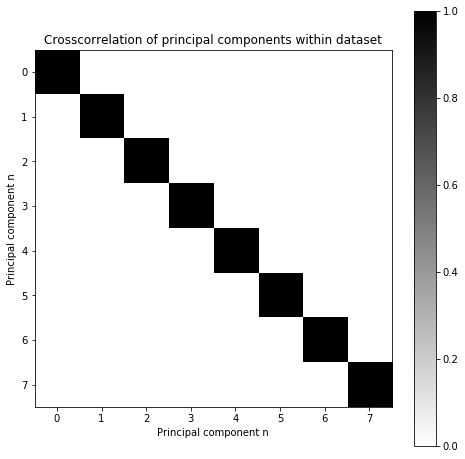

In [39]:
plt.figure(figsize = (8, 8))
plt.imshow(np.corrcoef(all_pcs.transpose()), cmap = 'gist_yarg')
plt.xlabel("Principal component n")
plt.ylabel("Principal component n")
plt.title("Crosscorrelation of principal components within dataset")
plt.colorbar()
plt.show()

### Crosscorrelation is effectively zero for all PC pairs. Consider distributions of each PC independent from each other PC.

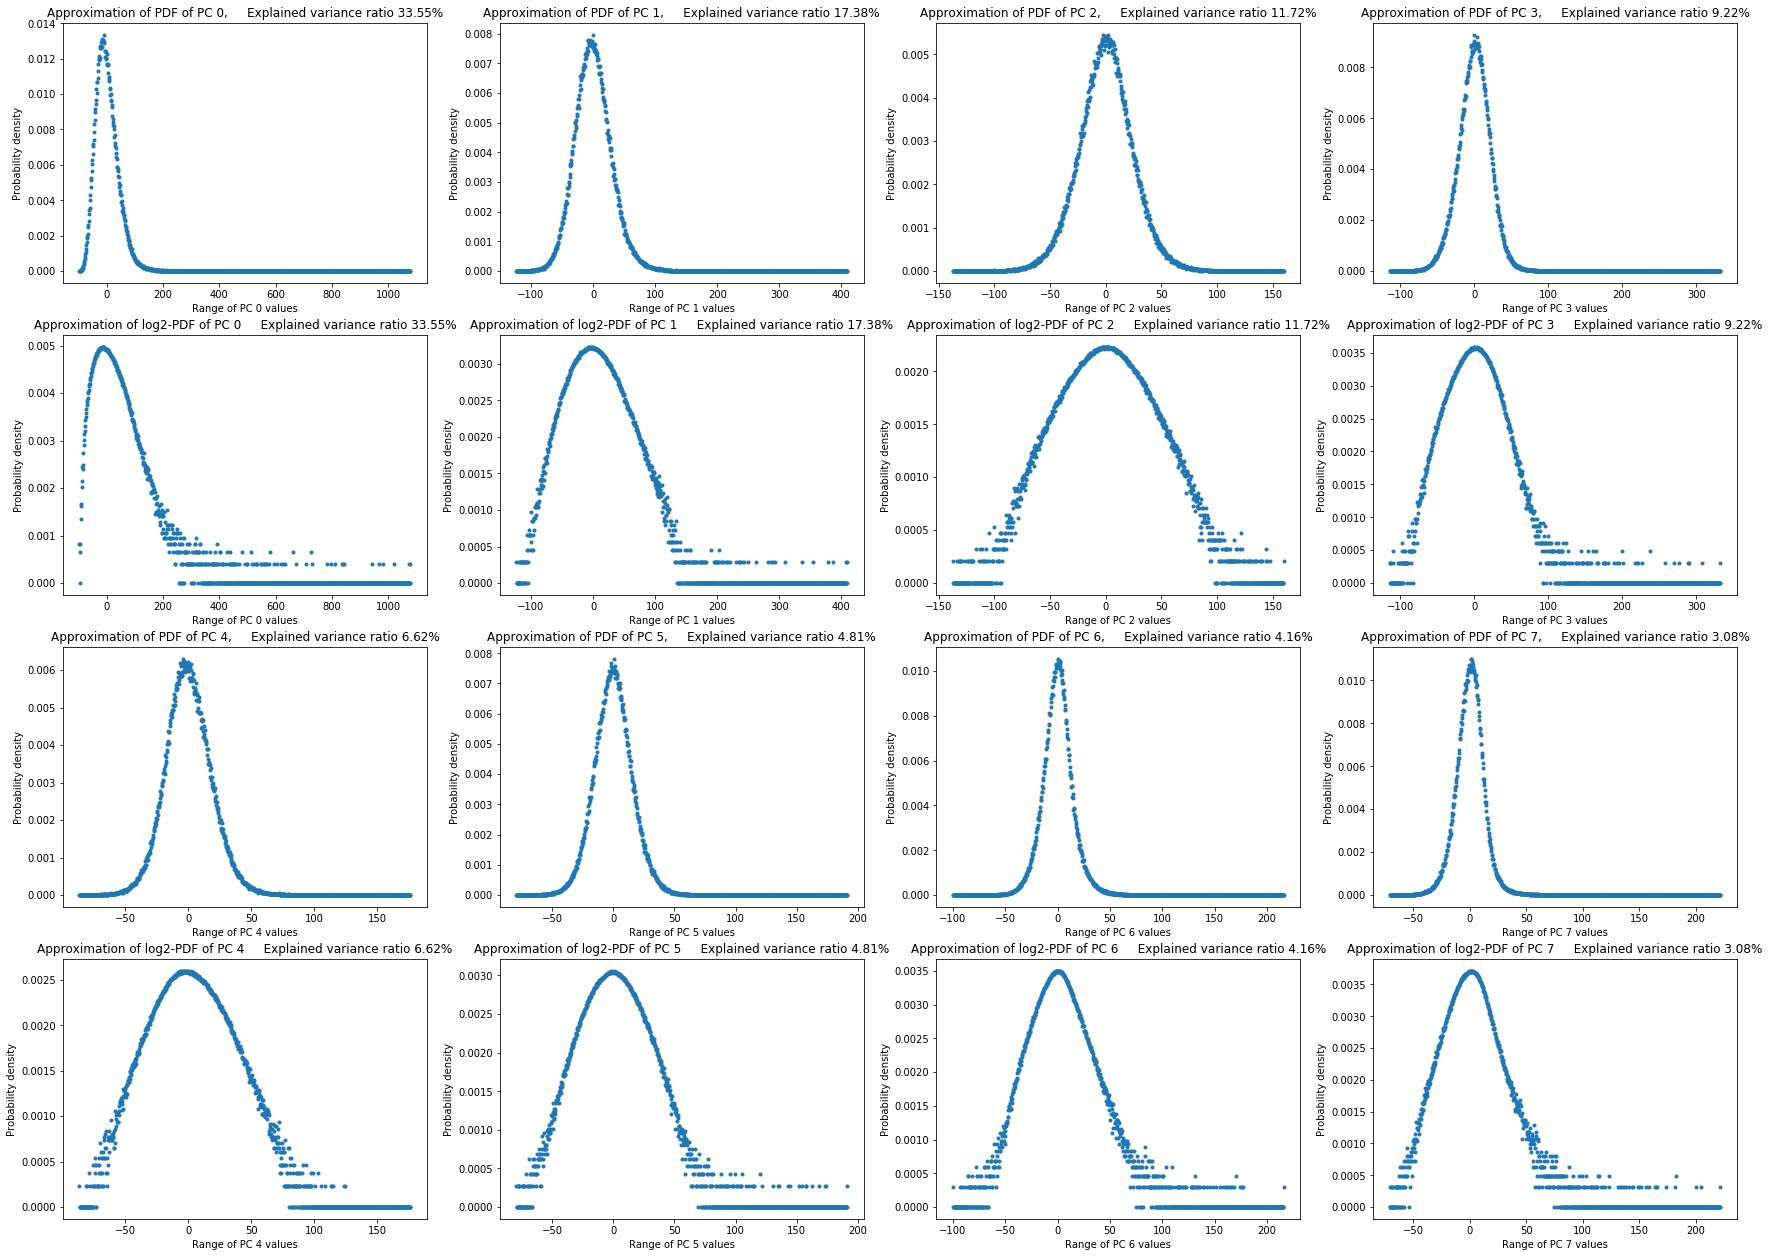

In [40]:
plt.figure(figsize = (30, 22))
for idx, (pos1, pos2) in zip(
    range(0, n_components),
    [(1, 5), (2, 6), (3, 7), (4, 8),
     (9, 13), (10, 14), (11, 15), (12, 16)]
):
    xs, ys, yslg2 = aprx_pdf_1d(all_pcs[ : , idx])
        
    plt.subplot(4, 4, pos1)
    plt.xlabel(f"Range of PC {idx} values")
    plt.ylabel(f"Probability density")
    plt.title(f"Approximation of PDF of PC {idx}, \
    Explained variance ratio {round(pca_model.explained_variance_ratio_[idx] * 100, 2)}%")
    plt.plot(xs, ys, '.')
    
    plt.subplot(4, 4, pos2)
    plt.xlabel(f"Range of PC {idx} values")
    plt.ylabel(f"Probability density")
    plt.title(f"Approximation of log2-PDF of PC {idx} \
    Explained variance ratio {round(pca_model.explained_variance_ratio_[idx] * 100, 2)}%")
    plt.plot(xs, yslg2, '.')
    
plt.savefig("../_data/PCA/PCA5.PDFs.png")
plt.show()

### Consider individual PCs.

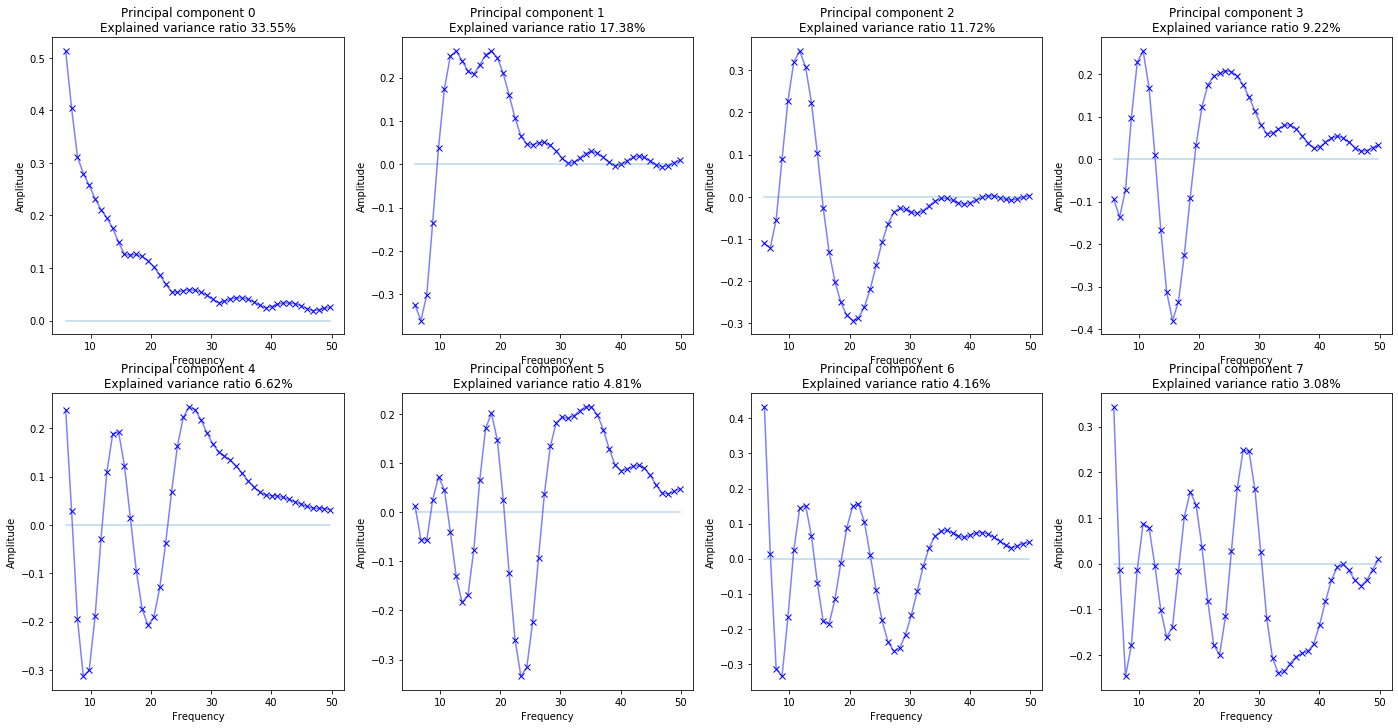

In [41]:
plt.figure(figsize = (24, 12))
for idx in range(0, n_components):
    plt.subplot(2, 4, idx + 1)
    plt.plot(freqs, pca_model.components_[idx], 'bx')
    plt.plot(freqs, pca_model.components_[idx], 'b', alpha = 0.5)
    plt.plot([np.min(freqs), np.max(freqs)], [0, 0], alpha = 0.3)
    plt.title(f"Principal component {idx} \
    \nExplained variance ratio {round(pca_model.explained_variance_ratio_[idx] * 100, 2)}%")
    plt.xlabel("Frequency")
    plt.ylabel("Amplitude")
plt.savefig("../_data/PCA/PCA5.PCs.png")
plt.show()

### Consider STR and GP channels.

In [42]:
pcs_str = []
pcs_gp  = []
for session, channels in dataDict.items():
    for channel, vals in channels.items():
        if "str_lfp" in channel:
            pcs_str.append(vals[ : , epoch_idxs])
        if "gp_lfp" in channel:
            pcs_gp. append(vals[ : , epoch_idxs])
pcs_str = pca_model.transform(np.concatenate(pcs_str, axis = 0))
pcs_gp  = pca_model.transform(np.concatenate(pcs_gp , axis = 0))

print(pcs_str.shape)
print(pcs_gp.shape)

(131208, 8)
(236421, 8)


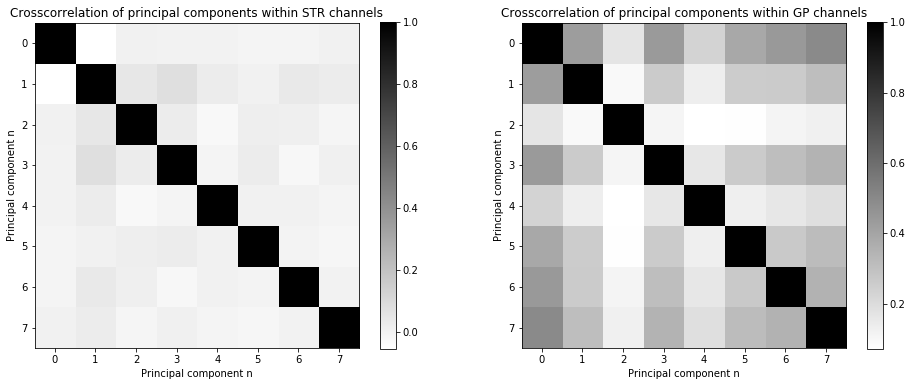

In [43]:
plt.figure(figsize = (16, 6))

plt.subplot(1, 2, 1)
plt.imshow(np.corrcoef(pcs_str.transpose()), cmap = 'gist_yarg')
plt.xlabel("Principal component n")
plt.ylabel("Principal component n")
plt.title("Crosscorrelation of principal components within STR channels")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(np.corrcoef(pcs_gp.transpose()), cmap = 'gist_yarg')
plt.xlabel("Principal component n")
plt.ylabel("Principal component n")
plt.title("Crosscorrelation of principal components within GP channels")
plt.colorbar()

plt.show()

### Exclude ones to better visualize deviations from zero (notably absent in full dataset).

In [44]:
excludeones_str, excludeones_gp = [np.array([
    np.concatenate((corrm[idx, :idx], corrm[idx, idx + 1:]))
    for idx in range(0, 8)
]) for corrm in (
    np.corrcoef(pcs_str.transpose()), 
    np.corrcoef(pcs_gp .transpose())
)]

excludeones_str = np.abs(excludeones_str)
excludeones_gp  = np.abs(excludeones_gp)

for idx, (row_str, row_gp) in enumerate(zip(excludeones_str, excludeones_gp)):
    print(f"Maximum absolute crosscorrelation between principal component {idx} and other, excluding self\n" + \
          f"\tSTR:\t{round(np.max(row_str), 2)}\n\tGP:\t{round(np.max(row_gp), 2)}\n")

Maximum absolute crosscorrelation between principal component 0 and other, excluding self
	STR:	0.05
	GP:	0.5

Maximum absolute crosscorrelation between principal component 1 and other, excluding self
	STR:	0.08
	GP:	0.43

Maximum absolute crosscorrelation between principal component 2 and other, excluding self
	STR:	0.05
	GP:	0.17

Maximum absolute crosscorrelation between principal component 3 and other, excluding self
	STR:	0.08
	GP:	0.44

Maximum absolute crosscorrelation between principal component 4 and other, excluding self
	STR:	0.03
	GP:	0.23

Maximum absolute crosscorrelation between principal component 5 and other, excluding self
	STR:	0.03
	GP:	0.39

Maximum absolute crosscorrelation between principal component 6 and other, excluding self
	STR:	0.04
	GP:	0.44

Maximum absolute crosscorrelation between principal component 7 and other, excluding self
	STR:	0.03
	GP:	0.5



### Crosscorrelations notably higher. Still plot approximate PDFs.

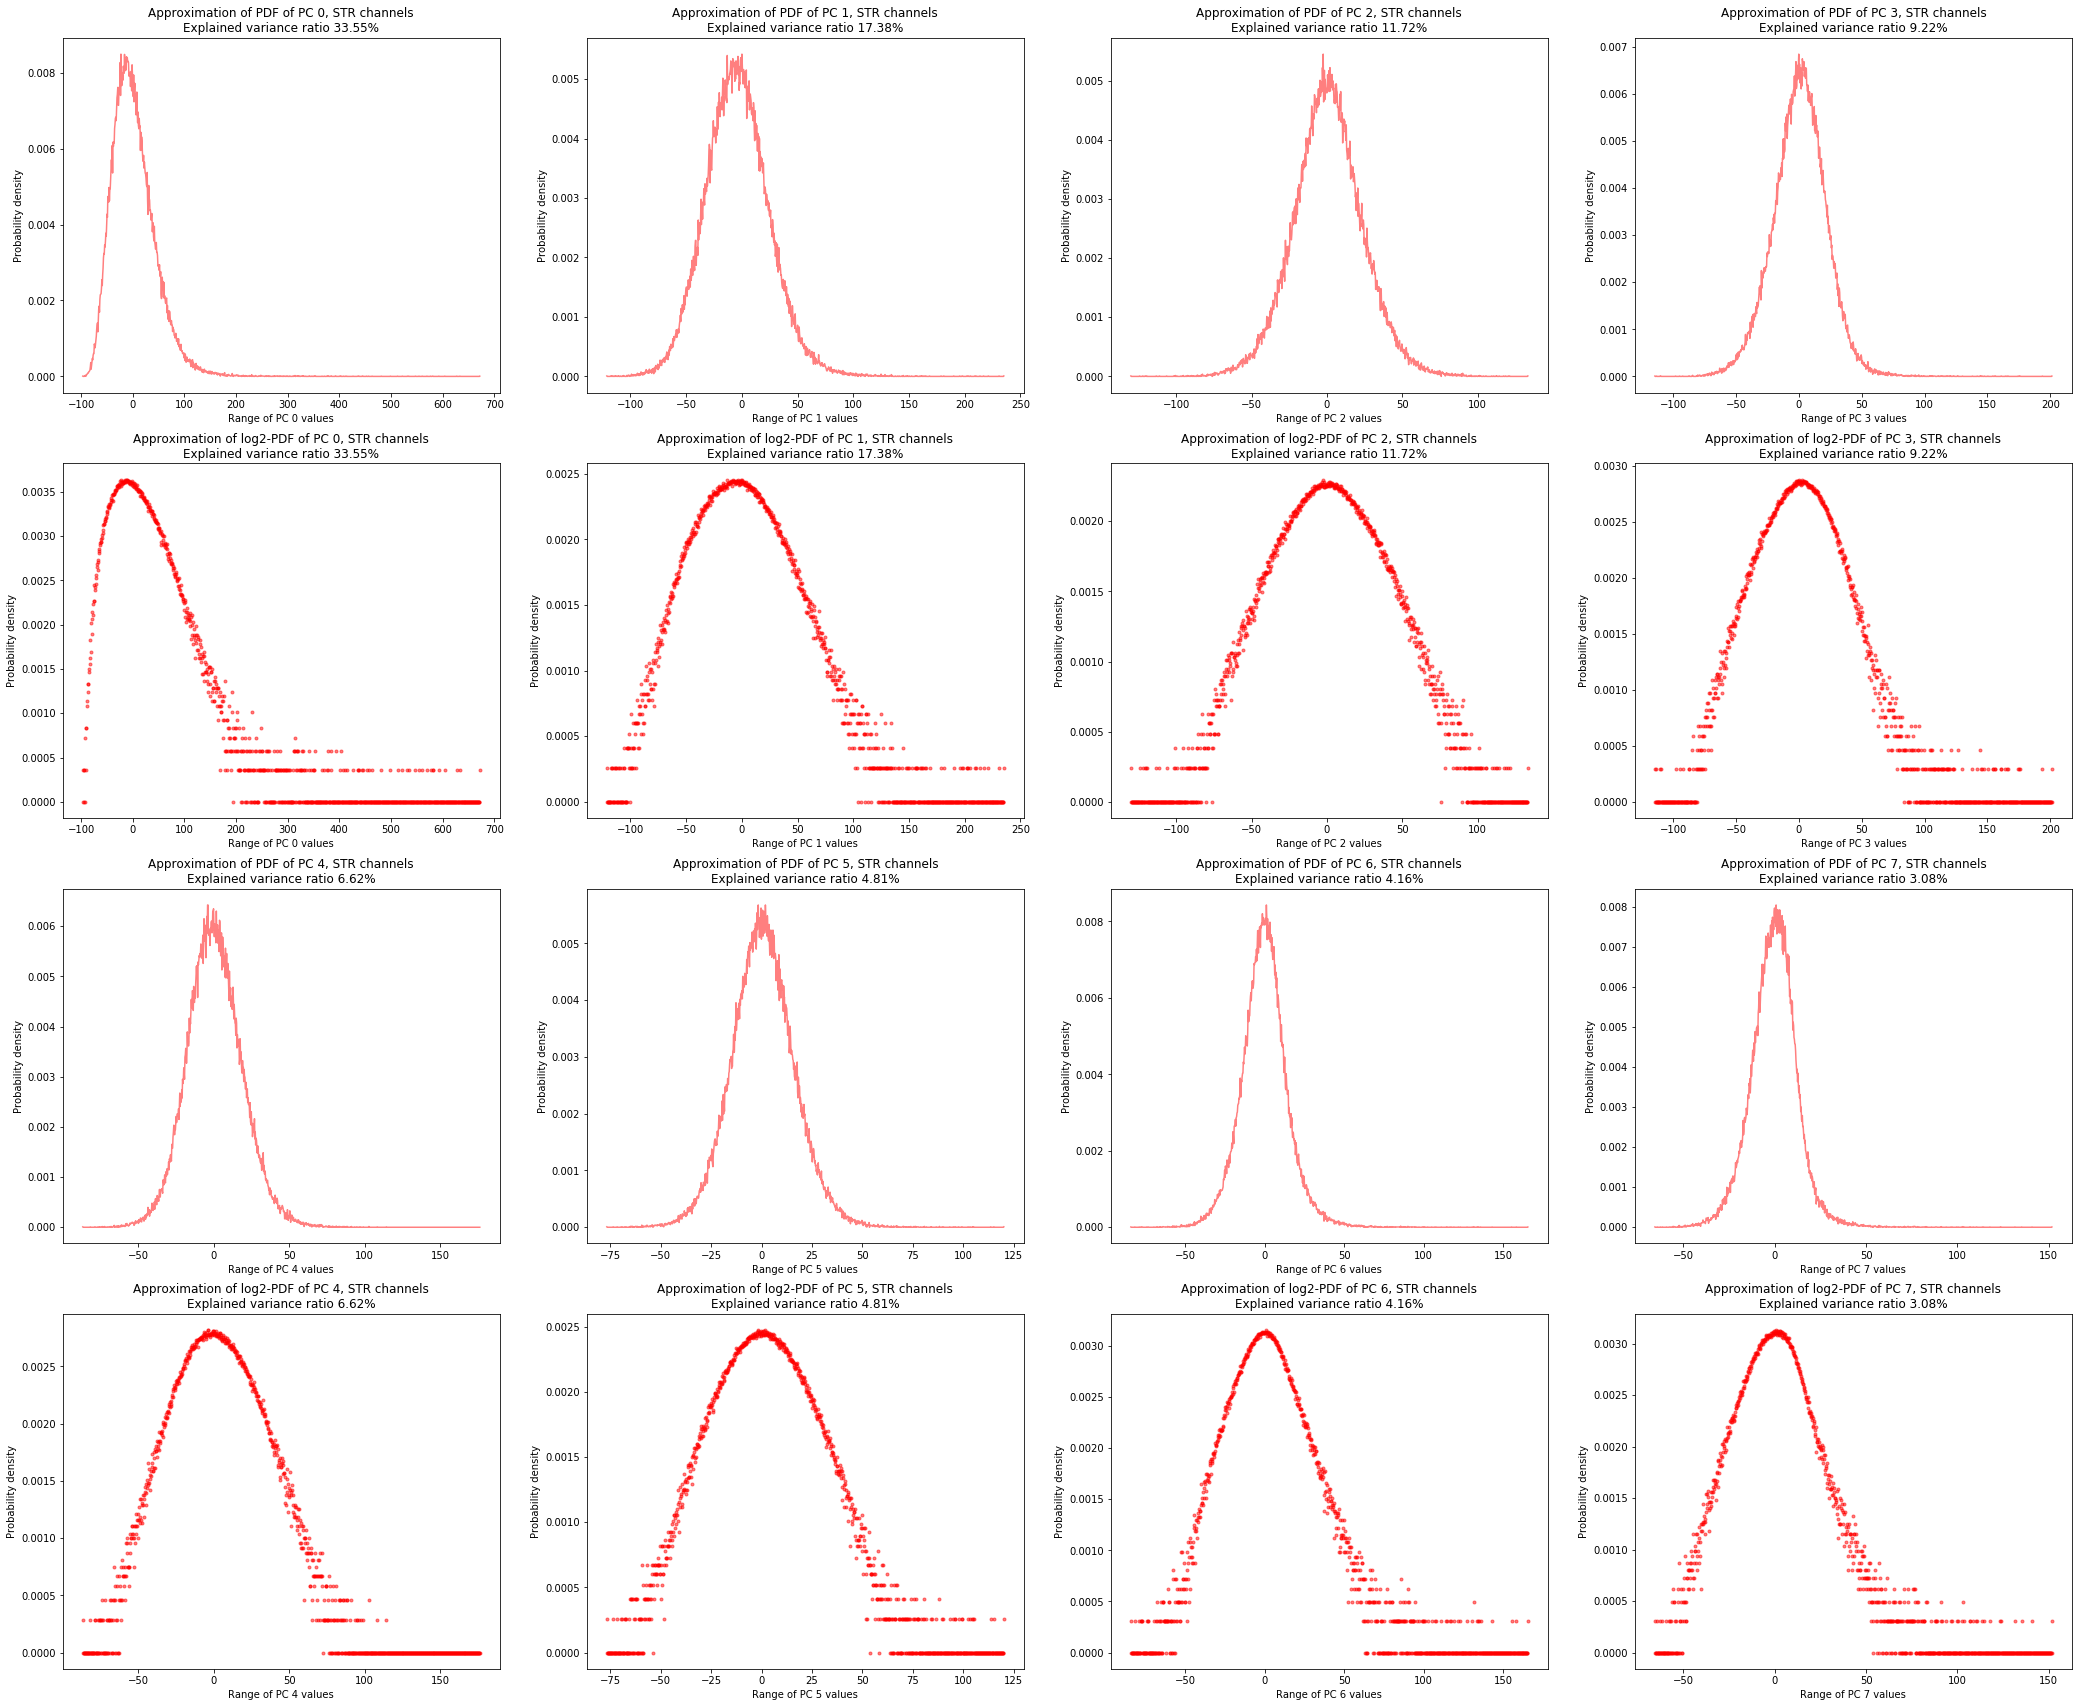

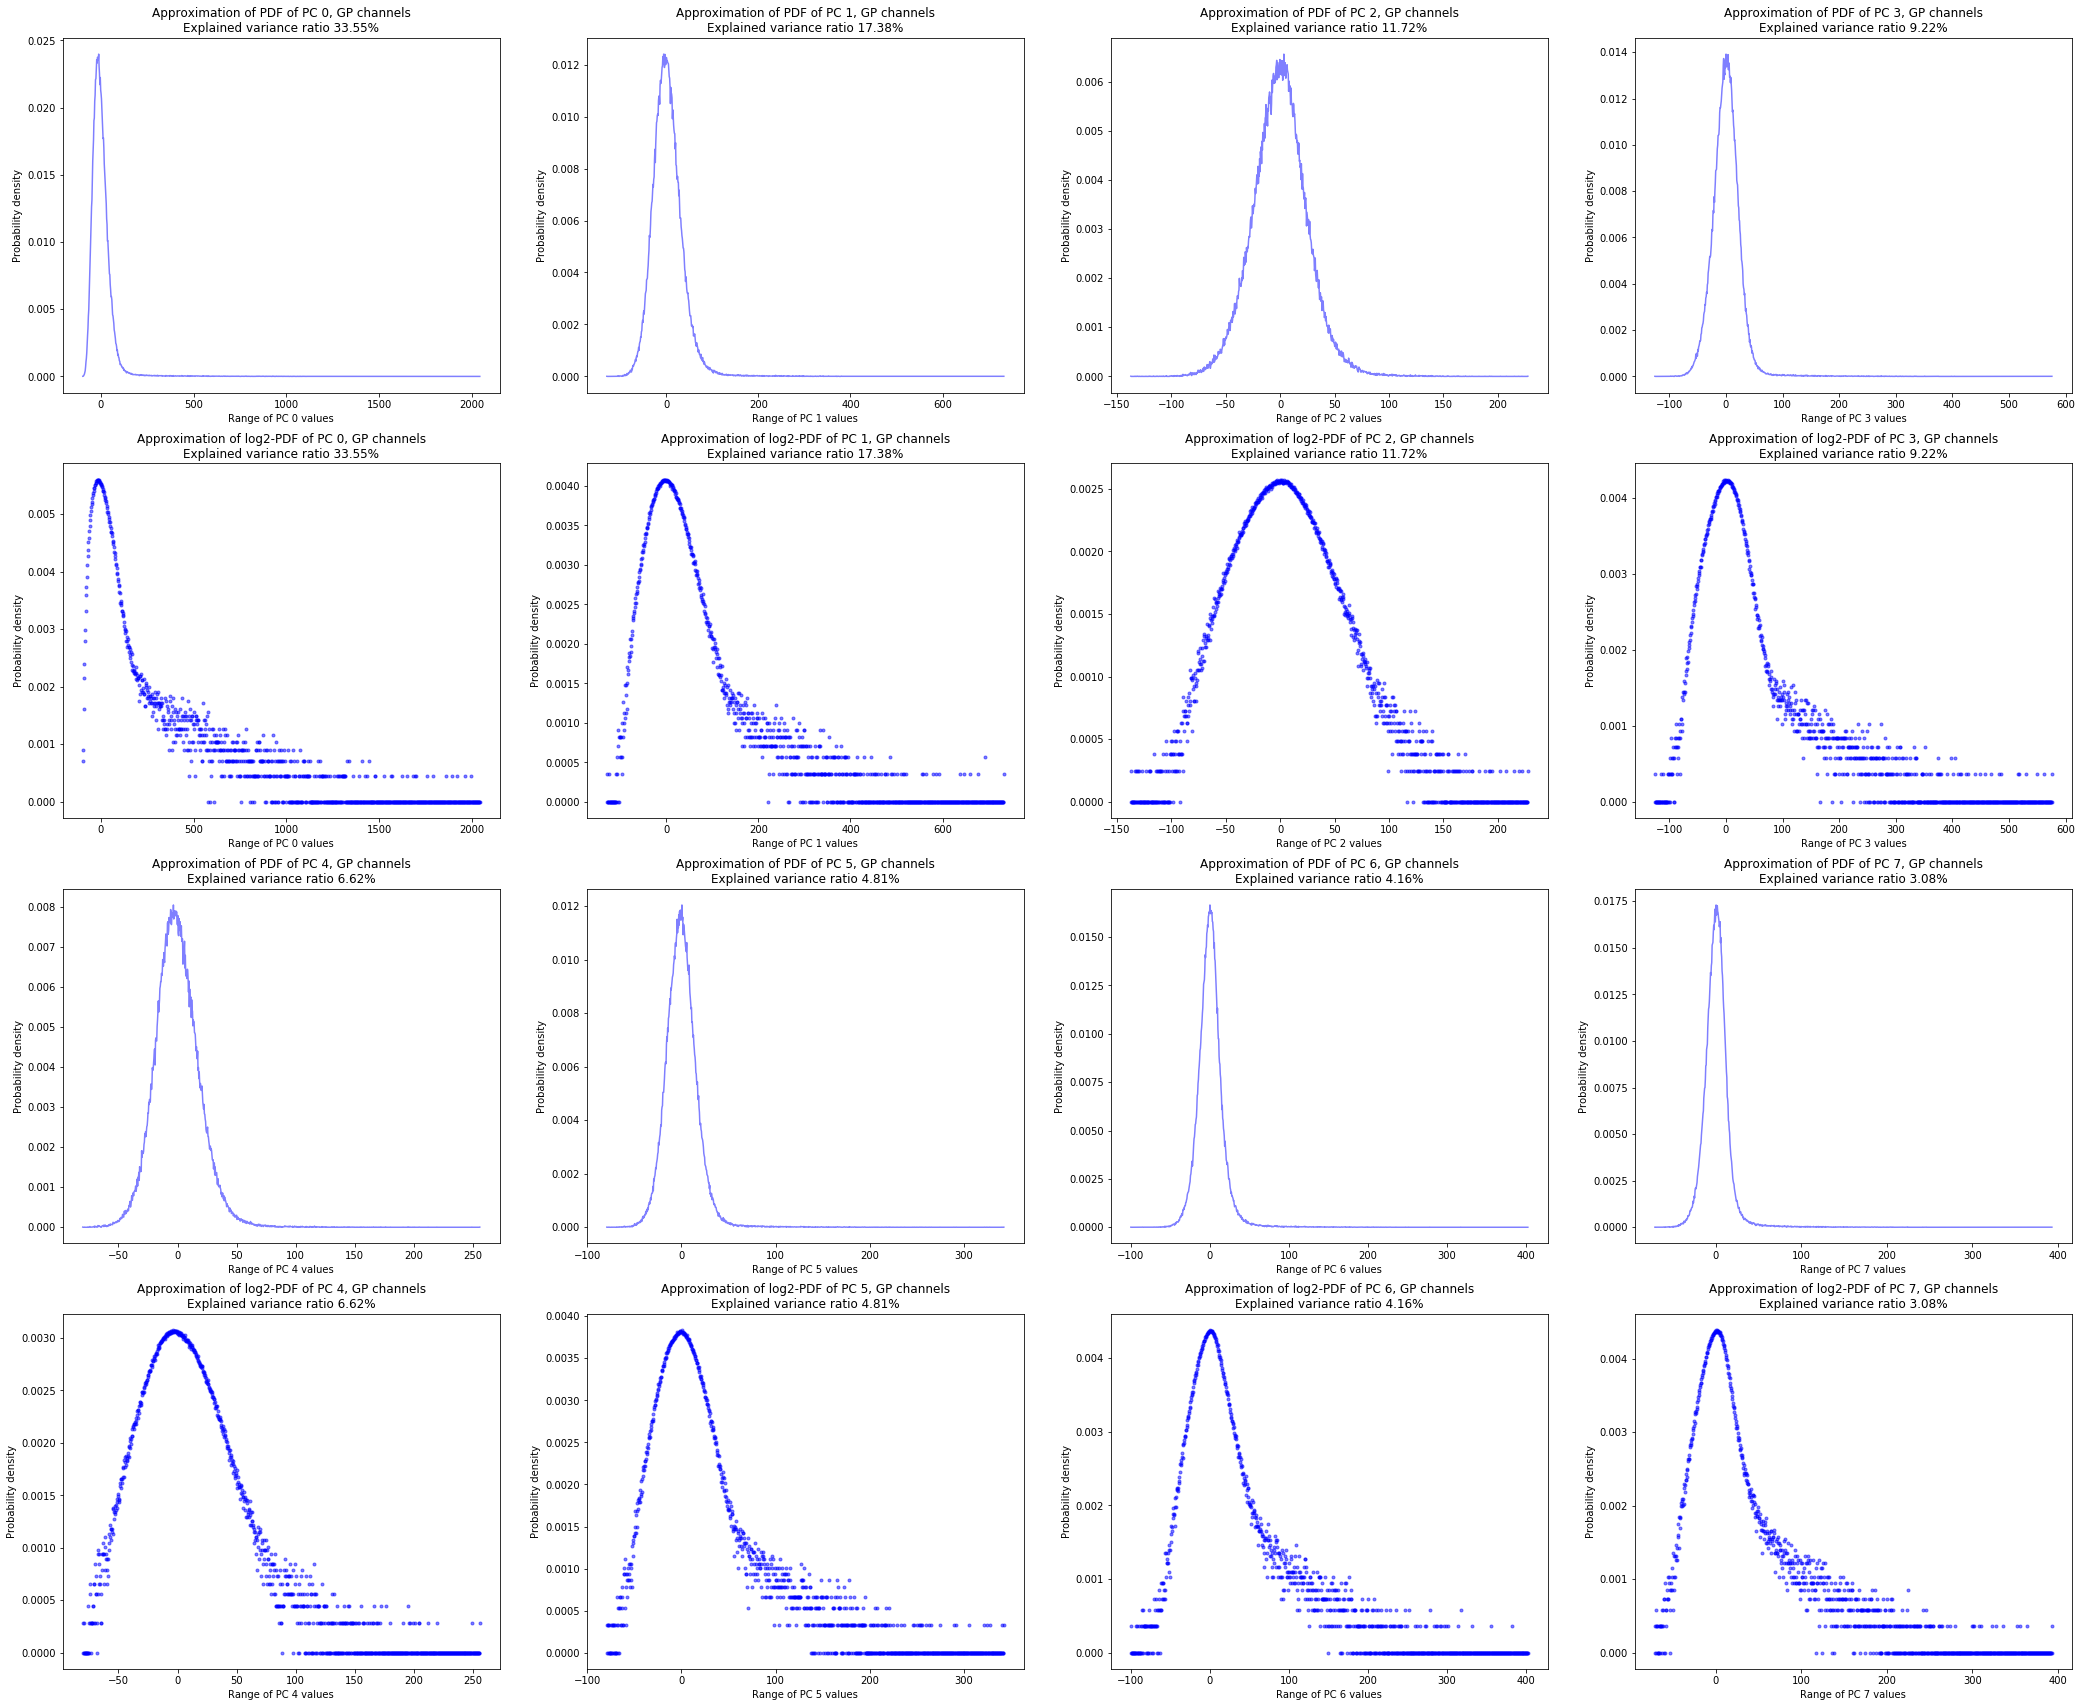

In [45]:
for channel, pcs, col in zip(["STR", "GP"], [pcs_str, pcs_gp], ['r', 'b']):
    plt.figure(figsize = (36, 30))
    for idx, (pos1, pos2) in zip(
        range(0, n_components),
        [(1, 5), (2, 6), (3, 7), (4, 8),
         (9, 13), (10, 14), (11, 15), (12, 16)]
    ):
        xs, ys, yslg2 = aprx_pdf_1d(pcs[ : , idx])

        plt.subplot(4, 4, pos1)
        plt.xlabel(f"Range of PC {idx} values")
        plt.ylabel(f"Probability density")
        plt.title(f"Approximation of PDF of PC {idx}, {channel} channels" + \
        f"\nExplained variance ratio {round(pca_model.explained_variance_ratio_[idx] * 100, 2)}%")
        plt.plot(xs, ys, col, alpha = 0.5)

        plt.subplot(4, 4, pos2)
        plt.xlabel(f"Range of PC {idx} values")
        plt.ylabel(f"Probability density")
        plt.title(f"Approximation of log2-PDF of PC {idx}, {channel} channels" + \
        f"\nExplained variance ratio {round(pca_model.explained_variance_ratio_[idx] * 100, 2)}%")
        plt.plot(xs, yslg2, col + '.', alpha = 0.5)

    plt.savefig(f"../_data/PCA/PCA5.PDFs.{channel}.png")
    plt.show()
    plt.close()

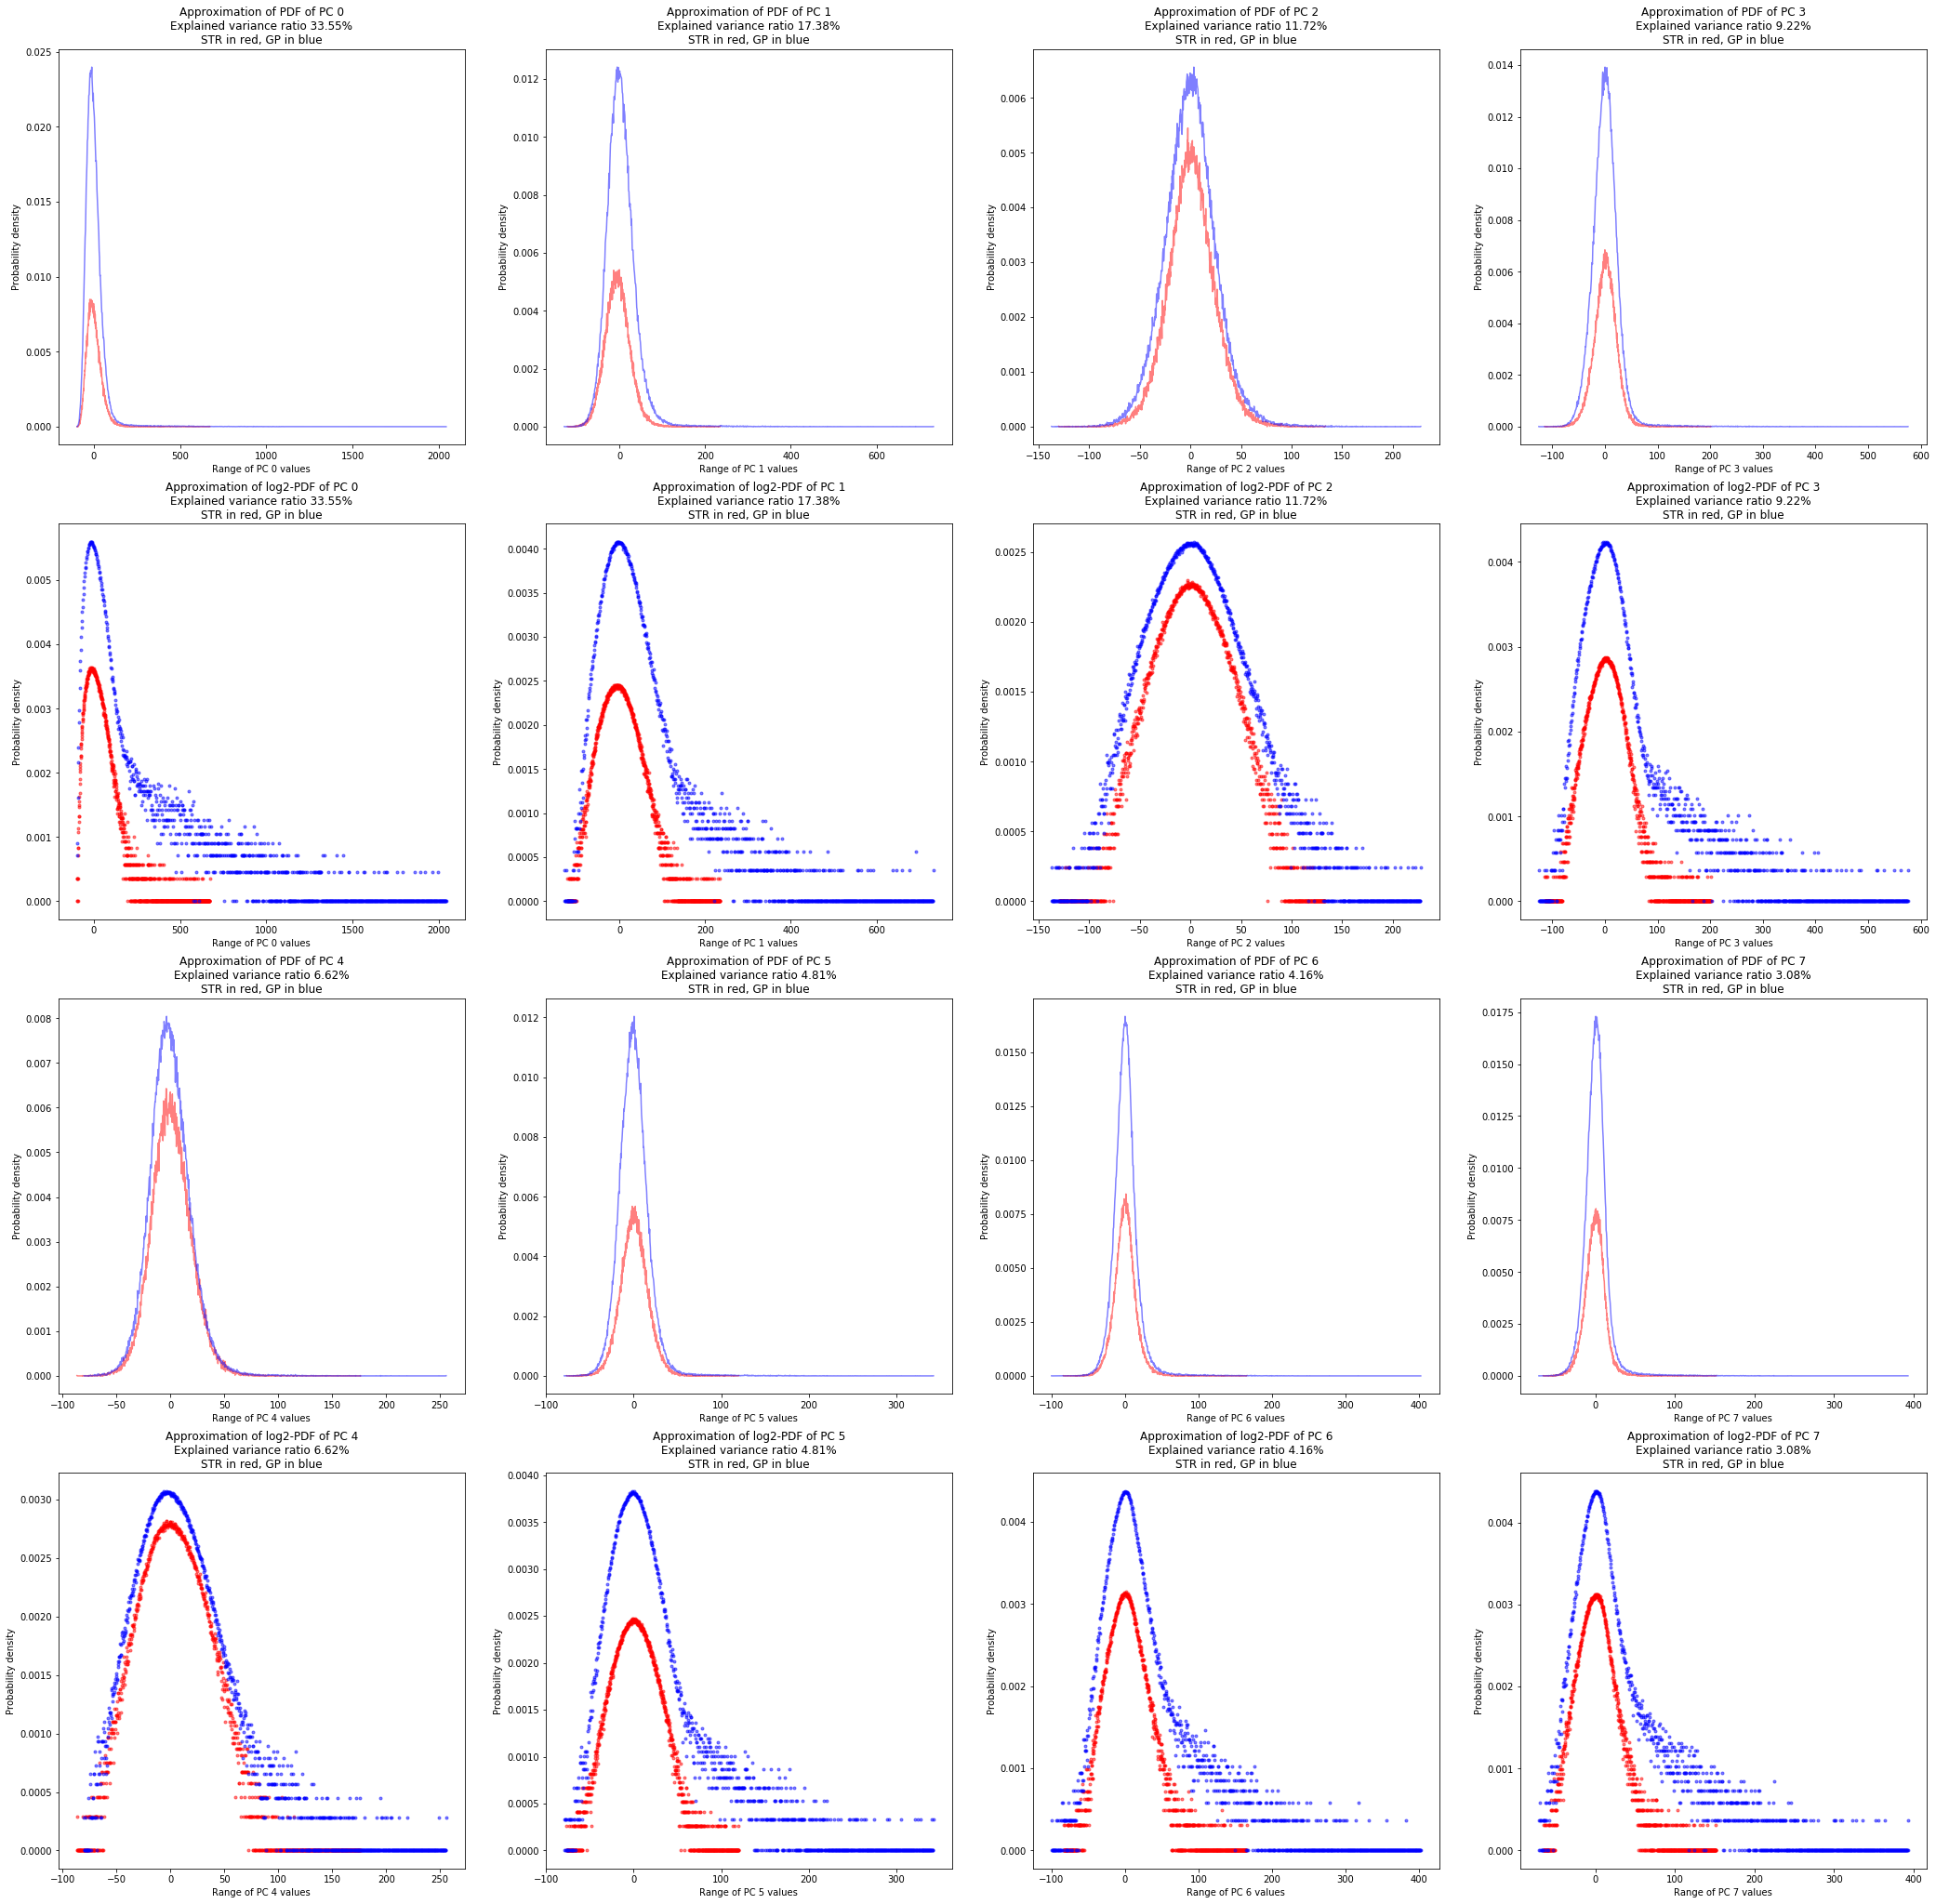

In [46]:
plt.figure(figsize = (36, 36))
for idx, (pos1, pos2) in zip(
    range(0, n_components),
    [(1, 5), (2, 6), (3, 7), (4, 8),
     (9, 13), (10, 14), (11, 15), (12, 16)]
):
    xs_str, ys_str, yslg2_str = aprx_pdf_1d(pcs_str[ : , idx])
    xs_gp , ys_gp , yslg2_gp  = aprx_pdf_1d(pcs_gp [ : , idx])

    plt.subplot(4, 4, pos1)
    plt.xlabel(f"Range of PC {idx} values")
    plt.ylabel(f"Probability density")
    plt.title(f"Approximation of PDF of PC {idx}" + \
    f"\nExplained variance ratio {round(pca_model.explained_variance_ratio_[idx] * 100, 2)}%" + \
    f"\nSTR in red, GP in blue")
    plt.plot(xs_str, ys_str, 'r', alpha = 0.5)
    plt.plot(xs_gp , ys_gp , 'b', alpha = 0.5)

    plt.subplot(4, 4, pos2)
    plt.xlabel(f"Range of PC {idx} values")
    plt.ylabel(f"Probability density")
    plt.title(f"Approximation of log2-PDF of PC {idx}" + \
    f"\nExplained variance ratio {round(pca_model.explained_variance_ratio_[idx] * 100, 2)}%" + \
    f"\nSTR in red, GP in blue")
    plt.plot(xs_str, yslg2_str, 'r.', alpha = 0.5)
    plt.plot(xs_gp , yslg2_gp , 'b.', alpha = 0.5)

plt.savefig(f"../_data/PCA/PCA5.PDFs.both.png")
plt.show()
plt.close()